In [38]:
!pip install datasets
!pip install sacrerouge sacrebleu bert-score

!pip install sentencepiece
!git clone https://github.com/huggingface/transformers.git
!pip install ./transformers/.

!pip install mosestokenizer

In [39]:
!sudo apt-get install --reinstall libxml-libxml-perl
!sacrerouge setup-metric rouge

**Task 1**

# **Deliverable 1.1 : T5 model**

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoModelForSeq2SeqLM
from sklearn.model_selection import train_test_split

model = T5ForConditionalGeneration.from_pretrained('t5-small').to('cuda')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

import torch
torch.cuda.empty_cache()

from datasets import load_dataset

## **Bible para dataset for translation**

In [ ]:
prefix = "translate English to French: "
lang1 = 'en'
lang2 = 'fr'
test_size = 0.1
dataset_size = 100

def create_batch(dataset, lang1=lang1, lang2=lang2, tokenizer=tokenizer, prefix=prefix, max_len=512):
  batch_input = [prefix + i[lang1] for i in dataset]
  batch_output = [i[lang2] for i in dataset]
  input_encodings = tokenizer.batch_encode_plus(batch_input, padding=True, max_length=max_len, truncation=True, return_tensors="pt").input_ids
  target_encodings = tokenizer.batch_encode_plus(batch_output, padding=True, max_length=max_len, truncation=True, return_tensors="pt").input_ids
  return batch_input, batch_output, input_encodings.to('cuda'), target_encodings.to('cuda')

bible_para = load_dataset('bible_para', lang1=lang1, lang2=lang2)['train']['translation']

train_set, test_set = train_test_split(bible_para, test_size=0.1)
test_set = test_set[:dataset_size]

test_input_bible, test_target_bible, test_input_encodings_bible, test_output_encodings_bible = create_batch(test_set)

In [52]:
# test bible dataset
result_bible = model.generate(test_input_encodings_bible, max_length=512)
model_output_decoded_bible = tokenizer.batch_decode(result_bible, skip_special_tokens=True)
i=0
for input, prediction, true in zip(test_input_bible, model_output_decoded_bible, test_target_bible):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(input,true,prediction, model_prediction))
  i+=1
  if i == 5:
    break

source:	 translate English to French: In the beginning God created the heavens and the earth.
target:	Au commencement, Dieu créa les cieux et la terre.
generated	Au début, Dieu créa les cieux et la terre.
------

source:	 translate English to French: Now the earth was formless and empty. Darkness was on the surface of the deep. God's Spirit was hovering over the surface of the waters.
target:	La terre était informe et vide: il y avait des ténèbres à la surface de l`abîme, et l`esprit de Dieu se mouvait au-dessus des eaux.
generated	Maintenant, la terre était sans forme et vide, la fébrilité était sur la surface du profond, l'Esprit de Dieu a établi un arrière-plan sur la surface des eaux.
------

source:	 translate English to French: God said, "Let there be light," and there was light.
target:	Dieu dit: Que la lumière soit! Et la lumière fut.
generated	Dieu disait : « La lumière ne s'en trouve pas », et il y a de la lumière.
------

source:	 translate English to French: God saw the lig

## **Xsum dataset for summarization**

In [ ]:
prefix = "summarize :"
dataset_size = 100

def create_batch(dataset, dataset_size=dataset_size, prefix=prefix, tokenizer=tokenizer, max_len=512):
    batch_input = [prefix + elt for elt in dataset['document'][:dataset_size]]
    batch_output = [elt for elt in dataset['summary'][:dataset_size]]
    input_encodings = tokenizer.batch_encode_plus(batch_input, padding=True, max_length=max_len, truncation=True, return_tensors="pt").input_ids
    target_encodings = tokenizer.batch_encode_plus(batch_output, padding=True, max_length=max_len, truncation=True, return_tensors="pt").input_ids
    return batch_input, batch_output, input_encodings.to('cuda'), target_encodings

xsum = load_dataset('xsum')
train_set = xsum['train']
test_set = xsum['test']

test_set = test_set[:dataset_size]

test_input_cnn, test_target_cnn, test_input_encodings_cnn, test_output_encodings_cnn = create_batch(test_set)

In [54]:
# test xsum dataset
result_cnn = model.generate(test_input_encodings_cnn, max_length=512)
model_output_decoded_cnn = tokenizer.batch_decode(result_cnn, skip_special_tokens=True)
i=0
for input, prediction, true in zip(test_input_cnn, model_output_decoded_cnn, test_target_cnn):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(input,true,prediction, model_prediction))
  i+=1
  if i == 5:
    break

source:	 summarize :Fast forward about 20 years, and it's fair to say he has done just that.
The business he runs, Frasers Hospitality, is one of the world's biggest providers of high-end serviced apartments. Its 148 properties span about 80 capital cities, as well as financial hubs across Europe, Asia, the Middle East and Africa.
But it almost didn't get off the ground.
When Mr Choe was appointed to launch and lead the company, Asia was booming; the tiger economies of Hong Kong, South Korea, Taiwan and Singapore were expanding rapidly.
But as Frasers prepared to open its first two properties in Singapore, the Asian financial crisis hit.
It was 1997. Currencies went into freefall. Suddenly, people were losing their jobs and stopped travelling.
Mr Choe recalls asking staff if they really wanted to continue working with the firm, because when the properties opened they might not get paid.
"It was really that serious," he says. "I remember tearing up because they said 'let's open it, let'

## **Test boolq dataset for question answering**

In [ ]:
dataset_size = 100

def create_batch(dataset, dataset_size=dataset_size, prefix=prefix, tokenizer=tokenizer, max_len=512):
    batch_input = ["question : " + question + ' context : ' + passage 
                   for question, passage in zip(dataset['question'][:dataset_size], 
                                                dataset['passage'][:dataset_size])]
    batch_output = [str(elt) for elt in dataset['answer'][:dataset_size]]
    input_encodings = tokenizer.batch_encode_plus(batch_input, padding=True, max_length=max_len, truncation=True, return_tensors="pt").input_ids
    target_encodings = tokenizer.batch_encode_plus(batch_output, padding=True, max_length=max_len, truncation=True, return_tensors="pt").input_ids
    return batch_input, batch_output, input_encodings.to('cuda'), target_encodings.to('cuda')

boolq = load_dataset('boolq')
train_set = boolq['train']
test_set = boolq['validation']

test_set = test_set[:dataset_size]

test_input_boolq, test_target_boolq, test_input_encodings_boolq, test_output_encodings_boolq = create_batch(test_set)

In [55]:
# test boolq dataset
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-boolq").to('cuda')

result_boolq = model.generate(test_input_encodings_boolq, max_length=512)
model_output_decoded_boolq = tokenizer.batch_decode(result_boolq, skip_special_tokens=True)
i=0
for input, prediction, true in zip(test_input_boolq, model_output_decoded_boolq, test_target_boolq):
  print("source:\t {}\ntarget:\t{}\ngenerated\t{}\n------\n".format(input,true,prediction, model_prediction))
  i+=1
  if i == 5:
    break

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


source:	 question : does ethanol take more energy make that produces context : All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For instance, a separate survey repo

# **Deliverable 1.2 : Rouge and Bleu implementation**


## **Rouge metric implementation**

### **Implementation and test of rouge-N on Xsum dataset**

In [7]:
# Implement metric rouge
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from mosestokenizer import MosesTokenizer

from sacrerouge.metrics import Rouge
rouge_true = Rouge(max_ngram=3, compute_rouge_l=True)


def rouge_n(true, pred, n):
    vectorizer = CountVectorizer(lowercase=False, ngram_range=(n, n))
    vectorizer.fit([true] + [pred])  

    true_counter = vectorizer.transform([true]).toarray()[0]
    pred_counter = vectorizer.transform([pred]).toarray()[0]

    matches = 0
    for true_elt, pred_elt in zip(true_counter, pred_counter):
      matches += min(true_elt, pred_elt)

    return matches/np.sum(true_counter)

In [49]:
# Test for rouge-n score

rouge_n_dict = {}
rouge_ns_dict = {}

for i in range(1, 4):
  rouge_n_list = []
  rouge_ns_list = []
  for true, pred in zip(test_target_cnn, model_output_decoded_cnn):
    rouge_n_list.append(rouge_n(true, pred, i)*100)
    rouge_ns_list.append(rouge_true.score(pred, [true])[f'rouge-{i}']['f1'])
  rouge_n_dict[f'rouge-{i}'] = np.mean(rouge_n_list)
  rouge_ns_dict[f'rouge-{i}'] = np.mean(rouge_ns_list)

### **Implementation and test of rouge-L on Xsum dataset**

In [50]:
# Own implementation of rouge-L
def lcs(a, b):
    """
    Compute the length of the longest common subsequence between two sequences.
    """
    if len(a) < len(b):
        a, b = b, a
    if len(b) == 0:
        return 0
    row = [0] * len(b)
    for ai in a:
        left = 0
        diag = 0
        for j, bj in enumerate(b):
            up = row[j]
            if ai == bj:
                value = diag + 1
            else:
                value = max(left, up)
            row[j] = value
            left = value
            diag = up
    return left

def rouge_l(true, pred):
    tokenizer = MosesTokenizer('en')
    true_tokens = tokenizer(true)
    pred_tokens = tokenizer(pred)
    matches = lcs(true_tokens, pred_tokens)
    return f1_score(matches, len(true_tokens), len(pred_tokens))

In [53]:
# Test for rouge-l score (comparison between our implementation and sacrerouge 
# implementations)
rouge_l_list = []
rouge_ls_list = []

for true, pred in zip(test_target_cnn, model_output_decoded_cnn):
  rouge_l_list.append(rouge_l(true, pred)*100)
  rouge_ls_list.append(rouge_true.score(pred, [true])['rouge-l']['f1'])

rouge_n_dict['rouge-l'] = np.mean(rouge_l_list)
rouge_ns_dict['rouge-l'] = np.mean(rouge_ls_list)

### **Dataframe comparaison between our implementation and sacrerouge for ROUGE metric**

In [52]:
# Dataframe comparaison for ROUGE
import pandas as pd
df_rouge = pd.DataFrame.from_records([rouge_n_dict, rouge_ns_dict], 
                                     index=['own_implementation', 'sacre-rouge'])
df_rouge

,rouge-1,rouge-2,rouge-3,rouge-l
own_implementation,3.07823,0.177866,0.00000,2.638141
sacre-rouge,3.14784,0.245940,0.05128,2.156430


As, we can see our implementation of the Rouge metric is not exactly the same as the one coded in sacrerouge (for the rouge-n and rouge-l). However, it is quite close (0.1% difference), maybe it is because we don't use the same tokenizer to split the sentences in token.
Moreover, concerning the xsum dataset, it doesn't give great results, as we could have expected when we looked on some examples.

## **Bleu metric implementation**

In [8]:
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def compute_pn(refs, candidate, n):
    vectorizer = CountVectorizer(lowercase=False, ngram_range=(n, n))
    vectorizer.fit(refs + candidate)  
    a = vectorizer.transform(refs).toarray()
    b = vectorizer.transform(candidate).toarray()

    sum = np.sum(a*b)
    sum_b = np.sum(b)
    return sum / sum_b

def compute_BP(refs, candidate):
    r = np.sum([len(c.split()) for c in refs])
    c = np.sum([len(c.split()) for c in candidate])
    if c > r:
      return 1
    else:
      return np.exp((1-r)/c)

def BLEU_star(ref, candidate, N, w):
    s = 0
    for n in range(1, N+1):
      pn = compute_pn([ref], [candidate], n)
      s += w*np.log(pn)
    BP = compute_BP([ref], [candidate])
    return 100*BP * np.exp(s)

In [99]:
import sacrebleu

# Test of our BLEU implementation metric on the bible dataset
N = 4
bleu_score = []
for input, prediction, true in zip(test_input_bible, model_output_decoded_bible, test_target_bible):
  bleu_score.append(BLEU_star(true, prediction, N, 1/N))

# Test of the sacrebleu BLEU implementation on the bible dataset
bleu = sacrebleu.corpus_bleu(model_output_decoded_bible, [test_target_bible]).score

# Comparison
print('Own implementation : ', np.mean(bleu_score))
print('Sacrebleu implementation : ', bleu)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


Own implementation :  13.53100109010626
Sacrebleu implementation :  14.316443259052077


As ROUGE, we have a difference between the results of our own implementation of BLEU and the implementation of sacrebleu, it can be because of the tokenizer.
However, the results on the bible test set is not very high compared to our expectations seeing the first translations.

## **F1-score for question answenring**

In [102]:
# This change in the answer is needed as it is clear that 'yes' corresponds to
# true in our application on the Boolq dataset.

true_to_yes = {
    'True': 'yes',
    'False': 'no'
}

def get_score_for_boolq_dataset(true, pred):
  true = true_to_yes[true]
  if true == pred:
    return 1
  return 0  

In [104]:
# Test our implementation of "f1-score"
f1_score_boolq = []
for true, pred in zip(test_target_boolq, model_output_decoded_boolq):
  f1_score_boolq.append(get_score_for_boolq_dataset(true, pred))

print(np.mean(f1_score_boolq))

0.75


The metric for Boolq dataset was not very developped because it's a dataset where you answers true or False, so the f1-score corresponds to the number of time you're right or not.
In the boolq dataset, we can see that the score is pretty high. It corresponds to what we saw on the example above.

# **Deliverable 1.3**

## **Implement all decoders functions**

In [14]:
# Implement beam search
def beam_search(input_ids, nb_beams, max_len=512):
  with torch.no_grad():
    decoder_input_ids = torch.zeros((1, 1)).int().to(device)

    sequences = [(decoder_input_ids, 1)]

    next_tok = 2

    while next_tok != 1 and sequences[0][0][0].size()[0] < max_len:
      new_sequences = []

      for decoder_input_id, prob in sequences:
        output = model(input_ids=input_ids, decoder_input_ids=decoder_input_id)
        probas = torch.softmax(output.logits[0, -1, :], dim=-1)
        next_tok_probas, next_tok_list = torch.topk(probas, nb_beams)

        for i in range(next_tok_probas.size()[0]):
          next_tok_prob = next_tok_probas[i].item()
          next_token = next_tok_list[i].view(1, 1)
          new_decoder_input_ids = torch.cat([decoder_input_id, next_token], dim=1).to(device)

          new_sequences.append((new_decoder_input_ids, prob*next_tok_prob))
            
      sequences = sorted(new_sequences, key=lambda x: x[1], reverse=True)[:nb_beams]


      next_tok = sequences[0][0][0][-1].view(1).item()

    
  return tokenizer.batch_decode(sequences[0][0], skip_special_tokens=True)

In [16]:
# Implement nucleus sampling
def nucleus_sampling(input_ids, top_p, max_len=512):
  with torch.no_grad():
      decoder_input_ids = torch.zeros((1, 1)).int().to(device)
      next_tok = decoder_input_ids

      while next_tok.view(1).item() != 1 and decoder_input_ids.size()[1] < max_len:
        output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
        
        probas = torch.softmax(output.logits[0, -1, :], dim=-1)
        
        prob, prob_indices = probas.sort(descending=True)
        cum_probas = prob.cumsum(dim=0)

        probas[prob_indices[cum_probas > top_p]] = 0

        if probas.sum() > 0:
          probas = probas/probas.sum()
          next_tok = torch.multinomial(probas, 1).view(1, 1)
       
        else:
          next_tok = prob_indices[0].view(1, 1)
        
        decoder_input_ids = torch.cat([decoder_input_ids, next_tok], dim=1).to(device)
  return tokenizer.batch_decode(decoder_input_ids, skip_special_tokens=True)

In [17]:
# Implement temperature samp
def temperature_sampling(input_ids, temperature, max_len=512):
  with torch.no_grad():
      decoder_input_ids = torch.zeros((1, 1)).int().to(device)
      next_tok = decoder_input_ids

      while next_tok.view(1).item() != 1 and decoder_input_ids.size()[1] < max_len:
        output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)
        
        probas = torch.softmax(output.logits[0, -1, :]/temperature, dim=-1)

        probas = probas/probas.sum()
        next_tok = torch.multinomial(probas, 1)

        decoder_input_ids = torch.cat([decoder_input_ids, next_tok.view(1,1)], 
                                      dim=1).to(device)

  return tokenizer.batch_decode(decoder_input_ids, skip_special_tokens=True)

## **Tests translation**

### **Test on text**

In [48]:
# Tests with n beams
for n in range(1, 5):
  i=0
  print(f'------- n-beams : {n} ----------')
  for input, true in zip(test_input_bible, test_target_bible):
    input_ids = tokenizer.batch_encode_plus([input], padding=True, max_length=512, 
                                            truncation=True, return_tensors="pt").input_ids.to(device)
    prediction = beam_search(input_ids, n)[0]
    model_prediction_ids = model.generate(input_ids, num_beams=n, max_length=512)
    model_prediction = tokenizer.batch_decode(model_prediction_ids, skip_special_tokens=True)[0]
    print("source:\t {}\ntarget:\t{}\nown generated\t{}\nModel generated\t{}\n------\n".format(input,true,prediction, model_prediction))
    i+= 1
    if i == 2: break

------- n-beams : 1 ----------
source:	 translate English to French: In the beginning God created the heavens and the earth.
target:	Au commencement, Dieu créa les cieux et la terre.
own generated	Au début, Dieu créa les cieux et la terre.
Model generated	Au début, Dieu créa les cieux et la terre.
------

source:	 translate English to French: Now the earth was formless and empty. Darkness was on the surface of the deep. God's Spirit was hovering over the surface of the waters.
target:	La terre était informe et vide: il y avait des ténèbres à la surface de l`abîme, et l`esprit de Dieu se mouvait au-dessus des eaux.
own generated	Maintenant, la terre était sans forme et vide, la fébrilité était sur la surface du profond, l'Esprit de Dieu a établi un aperçu de la surface des eaux.
Model generated	Maintenant, la terre était sans forme et vide, la fébrilité était sur la surface du profond, l'Esprit de Dieu a établi un aperçu de la surface des eaux.
------

------- n-beams : 2 ----------
sou

In [47]:
# Tests with nuclear samping
for top_p in [0.5, 0.7, 0.9, 0.95]:
  i=0
  print(f'------- top-p : {top_p} ----------')
  for input, true in zip(test_input_bible, test_target_bible):
    input_ids = tokenizer.batch_encode_plus([input], padding=True, max_length=512, 
                                            truncation=True, return_tensors="pt").input_ids.to(device)
    prediction = nucleus_sampling(input_ids, top_p)[0]
    model_prediction_ids = model.generate(input_ids, top_p=top_p, max_length=512)
    model_prediction = tokenizer.batch_decode(model_prediction_ids, skip_special_tokens=True)[0]
    print("source:\t {}\ntarget:\t{}\nown generated\t{}\nModel generated\t{}\n------\n".format(input,true,prediction, model_prediction))
    i+= 1
    if i == 2: break

------- top-p : 0.5 ----------
source:	 translate English to French: In the beginning God created the heavens and the earth.
target:	Au commencement, Dieu créa les cieux et la terre.
own generated	Au début, Dieu créa les cieux et la terre.
Model generated	Au début, Dieu créa les cieux et la terre.
------

source:	 translate English to French: Now the earth was formless and empty. Darkness was on the surface of the deep. God's Spirit was hovering over the surface of the waters.
target:	La terre était informe et vide: il y avait des ténèbres à la surface de l`abîme, et l`esprit de Dieu se mouvait au-dessus des eaux.
own generated	Maintenant, la terre était sans forme et vide, la foncée était sur la surface du profond, l'Esprit de Dieu s'élevait sur la surface des eaux.
Model generated	Maintenant, la terre était sans forme et vide, la fébrilité était sur la surface du profond, l'Esprit de Dieu a établi un aperçu de la surface des eaux.
------

------- top-p : 0.7 ----------
source:	 trans

In [46]:
# Tests with temperature with softmax
for t in [0.5, 0.7, 0.9]:
  i=0
  print(f'------- temperature : {t} ----------')
  for input, true in zip(test_input_bible, test_target_bible):
    input_ids = tokenizer.batch_encode_plus([input], padding=True, max_length=512, 
                                            truncation=True, return_tensors="pt").input_ids.to(device)
    prediction = temperature_sampling(input_ids, t)[0]
    model_prediction_ids = model.generate(input_ids, temperature=t, max_length=512)
    model_prediction = tokenizer.batch_decode(model_prediction_ids, skip_special_tokens=True)[0]
    print("source:\t {}\ntarget:\t{}\nown generated\t{}\nModel generated\t{}\n------\n".format(input,true,prediction, model_prediction))
    i+= 1
    if i == 2: break

------- temperature : 0.5 ----------
source:	 translate English to French: In the beginning God created the heavens and the earth.
target:	Au commencement, Dieu créa les cieux et la terre.
own generated	Au début, Dieu a créé les cieux et la terre.
Model generated	Au début, Dieu créa les cieux et la terre.
------

source:	 translate English to French: Now the earth was formless and empty. Darkness was on the surface of the deep. God's Spirit was hovering over the surface of the waters.
target:	La terre était informe et vide: il y avait des ténèbres à la surface de l`abîme, et l`esprit de Dieu se mouvait au-dessus des eaux.
own generated	Aujourd'hui, la terre était sans forme et vide, la féroce s'est installée sur la surface de la profondeur, et l'Esprit de Dieu a plongé sur la surface des eaux.
Model generated	Maintenant, la terre était sans forme et vide, la fébrilité était sur la surface du profond, l'Esprit de Dieu a établi un aperçu de la surface des eaux.
------

------- temperatur

### **Test with BLEU metric**

In [18]:
dict_bleu_metric = {
    'bleu_n_beams_1': [],
    'bleu_n_beams_2' : [],
    'bleu_n_beams_3' : [],
    'bleu_n_beams_4' : [],
    'bleu_top_p_0.5' : [],
    'bleu_top_p_0.7' : [],
    'bleu_top_p_0.9' : [],
    'bleu_top_p_0.95' : [],
    'bleu_top_p_0.5' : [],
    'bleu_temp_0.5' : [],
    'bleu_temp_0.7' : [],
    'bleu_temp_0.9' : []
    }

for input, true in zip(test_input_bible, test_target_bible):
  input_ids = tokenizer.batch_encode_plus([input], padding=True, max_length=512, 
                                          truncation=True, return_tensors="pt").input_ids.to(device)

  for n in [1, 2, 3, 4]:
    prediction = beam_search(input_ids, n)[0]
    dict_bleu_metric[f'bleu_n_beams_{n}'].append(BLEU_star(true, prediction, 4, 1/4))
  
  for top_p in [0.5, 0.7, 0.9, 0.95]:
    prediction = nucleus_sampling(input_ids, top_p)[0]
    dict_bleu_metric[f'bleu_top_p_{top_p}'].append(BLEU_star(true, prediction, 4, 1/4))
  
  for t in [0.5, 0.7, 0.9]:
    prediction = temperature_sampling(input_ids, t)[0]
    dict_bleu_metric[f'bleu_temp_{t}'].append(BLEU_star(true, prediction, 4, 1/4))

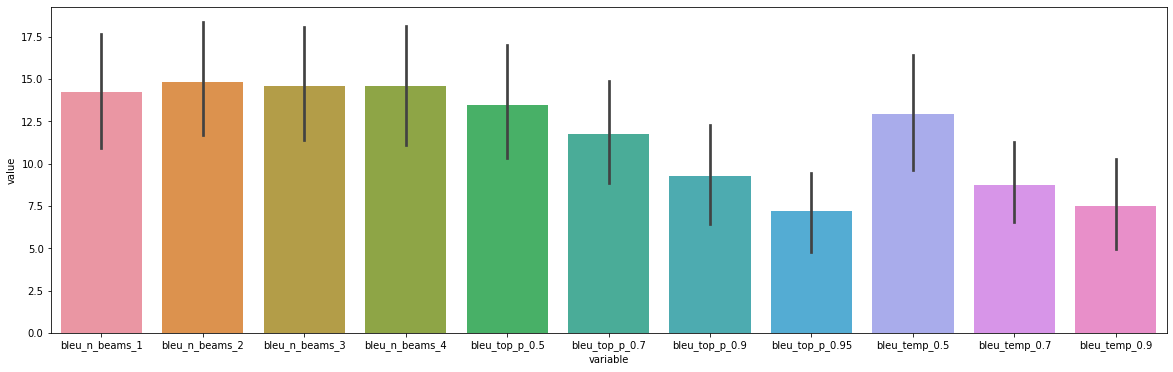

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_bleu = pd.DataFrame(dict_bleu_metric).reset_index()
decoding_melted = pd.melt(df_bleu, id_vars="index")
plt.figure(figsize=(20,6))
sns.barplot(data=decoding_melted, x="variable", y="value")
plt.show()

## **Test summarization**

### **Test with text**

In [45]:
# Tests with n beams
for n in [1, 2, 4]:
  i=0
  print(f'------- n-beams : {n} ----------')
  for input, true in zip(test_input_cnn, test_target_cnn):
    input_ids = tokenizer.batch_encode_plus([input], padding=True, max_length=512, 
                                            truncation=True, return_tensors="pt").input_ids.to(device)
    prediction = beam_search(input_ids, n)[0]
    model_prediction_ids = model.generate(input_ids, num_beams=n, max_length=512)
    model_prediction = tokenizer.batch_decode(model_prediction_ids, skip_special_tokens=True)[0]
    print("source:\t {}\ntarget:\t{}\nown generated\t{}\nModel generated\t{}\n------\n".format(input[:1000],true,prediction, model_prediction))
    i+= 1
    if i == 3: break

------- n-beams : 1 ----------
source:	 summarize :Fast forward about 20 years, and it's fair to say he has done just that.
The business he runs, Frasers Hospitality, is one of the world's biggest providers of high-end serviced apartments. Its 148 properties span about 80 capital cities, as well as financial hubs across Europe, Asia, the Middle East and Africa.
But it almost didn't get off the ground.
When Mr Choe was appointed to launch and lead the company, Asia was booming; the tiger economies of Hong Kong, South Korea, Taiwan and Singapore were expanding rapidly.
But as Frasers prepared to open its first two properties in Singapore, the Asian financial crisis hit.
It was 1997. Currencies went into freefall. Suddenly, people were losing their jobs and stopped travelling.
Mr Choe recalls asking staff if they really wanted to continue working with the firm, because when the properties opened they might not get paid.
"It was really that serious," he says. "I remember tearing up because

### **Test with ROUGE metric**

In [42]:
dict_rouge_metric = {
    'rouge_n_beams_1': [],
    'rouge_n_beams_2' : [],
    'rouge_n_beams_4' : [],
    'rouge_top_p_0.5' : [],
    'rouge_top_p_0.7' : [],
    'rouge_top_p_0.9' : [],
    'rouge_top_p_0.95' : [],
    'rouge_top_p_0.5' : [],
    'rouge_temp_0.5' : [],
    'rouge_temp_0.7' : [],
    'rouge_temp_0.9' : []
    }

for input, true in zip(test_input_cnn, test_target_cnn):
  input_ids = tokenizer.batch_encode_plus([input], padding=True, max_length=512, 
                                          truncation=True, return_tensors="pt").input_ids.to(device)

  for n in [1, 2, 4]:
    prediction = beam_search(input_ids, n)[0]
    score = rouge_true.score(prediction, [true])['rouge-l']['f1']
    dict_rouge_metric[f'rouge_n_beams_{n}'].append(score)
  
  for top_p in [0.5, 0.7, 0.9, 0.95]:
    prediction = nucleus_sampling(input_ids, top_p)[0]
    score = rouge_true.score(prediction, [true])['rouge-l']['f1']
    dict_rouge_metric[f'rouge_top_p_{top_p}'].append(score)
  
  for t in [0.5, 0.7, 0.9]:
    prediction = temperature_sampling(input_ids, t)[0]
    score = rouge_true.score(prediction, [true])['rouge-l']['f1']
    dict_rouge_metric[f'rouge_temp_{t}'].append(score)


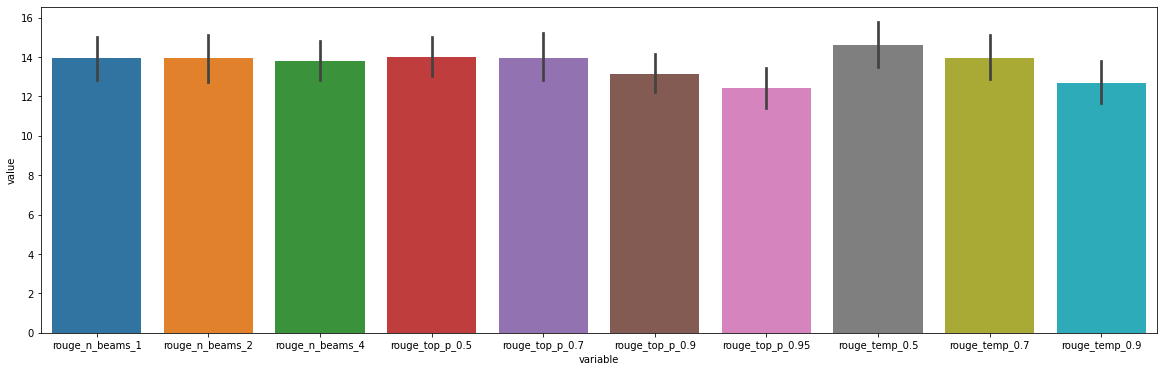

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_bleu = pd.DataFrame(dict_rouge_metric).reset_index()
decoding_melted = pd.melt(df_bleu, id_vars="index")
plt.figure(figsize=(20,6))
sns.barplot(data=decoding_melted, x="variable", y="value")
plt.show()

### Test for question answering

In [44]:
# Tests with n beams
for n in [1, 2, 4]:
  i=0
  print(f'------- n-beams : {n} ----------')
  for input, true in zip(test_input_boolq, test_target_boolq):
    input_ids = tokenizer.batch_encode_plus([input], padding=True, max_length=512, 
                                            truncation=True, return_tensors="pt").input_ids.to(device)
    prediction = beam_search(input_ids, n)[0]
    model_prediction_ids = model.generate(input_ids, num_beams=n, max_length=512)
    model_prediction = tokenizer.batch_decode(model_prediction_ids, skip_special_tokens=True)[0]
    print("source:\t {}\ntarget:\t{}\nown generated\t{}\nModel generated\t{}\n------\n".format(input,true,prediction, model_prediction))
    i+= 1
    if i == 3: break

------- n-beams : 1 ----------
source:	 question : does ethanol take more energy make that produces context : All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total amount of energy input into the process compared to the energy released by burning the resulting ethanol fuel is known as the energy balance (or ``energy returned on energy invested''). Figures compiled in a 2007 report by National Geographic Magazine point to modest results for corn ethanol produced in the US: one unit of fossil-fuel energy is required to create 1.3 energy units from the resulting ethanol. The energy balance for sugarcane ethanol produced in Brazil is more favorable, with one unit of fossil-fuel energy required to create 8 from the ethanol. Energy balance estimates are not easily produced, thus numerous such reports have been generated that are contradictory. For i

## **Report**

In this section, we implemented three different decoders for Natural Language generation : Translation, Summarization and Question answering. The three decoders are : n-beams decoder, nucleus sampling and temperature with Softmax sampling, parametrized respectively by : n-beams (number of beams), top-p (probability maximum of the cumulative sum of the probabilities) and temperature. 
We tested these decoders with different parametrization. Firstly, on a text-based aspect to see if the results were visually good (especially for translation and summarization). And then, we calculated metrics in order to evaluate these decoders. For the translation, we choose the BLEU metric that we created earlier on bible para dataset and for summarization, we choose the ROUGE-L metric implemented in scarerouge library on xsum dataset.

For machine translation, the best decoder turned out to be : the n-beams decoder in particular the 2-beams and 4-beams. It was expected because the beams decoder works really fine with translation as it computes the best probabilities of a suite of words.

For summarization, the best decoder turned out to be : the nucleus samping (in particular 0.5 for the top_p probability) and the n-beams look very great too. It can be due that summary is not about giving correct answers, so it has not a 'true' answer for this.

For question answering, no decoders seems to work well on the boolq dataset.

However, when we did some experiments with the three decoders, beam search reveals to be the most time consuming because beam search has an exponential complexity and therefore it becomes very time-consuming when n_beams increases. But, in the results, it turns out that when you increase the number of beans, it leads to better predictions. So, you have to find a compromise between rapidity and precision. Compared to the other 2 decoders that look pretty fast (as the sampling is done by pytorch and it is really optimized).

# Deliverable 2.1

In [ ]:
# Imports
import matplotlib.pyplot as plt
import seaborn
import numpy as np

# functions for 2.1

def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
def get_attentions(model, tokenizer, sentence, sample_index = 0, limit=None):
  # get ids of input
  input_ids = tokenizer(sentence, return_tensors="pt").input_ids.to("cuda")
  if limit:
    input_ids = input_ids[0][:limit].reshape((1, limit))
  # get ids of output
  output_ids = tokenizer(output_decoded, add_special_tokens=False, return_tensors="pt").input_ids.to("cuda")
  outputs = model(input_ids=input_ids, decoder_input_ids=output_ids, output_attentions=True)

  ## Step 3: Convert input and output into tokens
  input_id_list = input_ids[sample_index].tolist()
  tokens_in = tokenizer.convert_ids_to_tokens(input_id_list)

  output_id_list = output_ids[sample_index].tolist()
  tokens_out = tokenizer.convert_ids_to_tokens(output_id_list)
  return outputs, tokens_in, tokens_out

def plot_cross_attention(outputs, tokens_in, tokens_out, aggregation=False):
  if aggregation == True:
    for layer in range(0, 6, 1):
        fig, axs = plt.subplots(1,1, figsize=(10, 10))
        print("\nAttention Layer", layer+1)
        attention_sum = 0
        for h in range(8):
          attention_sum += outputs.cross_attentions[layer][0, h].cpu().data
        draw(attention_sum, 
            tokens_in, tokens_out, ax=axs)
        plt.show()
  else:
    for layer in range(0, 6, 1):
        fig, axs = plt.subplots(1,8, figsize=(30, 20))
        print("Attention Layer", layer+1)
        for h in range(8):
            draw(outputs.cross_attentions[layer][0, h].cpu().data, 
                tokens_in, tokens_out if h == 0 else [], ax=axs[h])
        plt.show()

## Bible para dataset for translation

In [ ]:
# # Poor performer
# sample_index = 46

#Good performer
sample_index = 56

## Step 1: apply model
model = T5ForConditionalGeneration.from_pretrained('t5-small',output_attentions=True).to('cuda')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
sentence = test_input_bible[sample_index]
sentence_tokenized = test_input_encodings_bible[sample_index]
# the translated sentence encoded (vector)
output = model.generate(sentence_tokenized.reshape((1,len(sentence_tokenized))),
                        max_length=512)
# the translated sentence decoded (string)
output_decoded = tokenizer.batch_decode(output, skip_special_tokens=True)


## Step 2 & 3: Recover info for vis
outputs, tokens_in, tokens_out = get_attentions(model, tokenizer, sentence, sample_index = 0)

## Step 4: Plot attention layers
plot_cross_attention(outputs, tokens_in, tokens_out, aggregation=False)

In [ ]:
plot_cross_attention(outputs, tokens_in, tokens_out, aggregation=True)

## CNN daily mail dataset for summarization

In [ ]:
# get a short text for visualisation purposes
for idx, i in enumerate(test_input_cnn):
  if len(i) < 500:
    print(i)
    print(idx)
    break

In [ ]:
## Step 1: apply model
model = T5ForConditionalGeneration.from_pretrained('t5-small',output_attentions=True).to('cuda')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# We use this example for simplicity
sentence = test_input_cnn[1]
# sentence = 'summarize :Fast forward about 20 years, and its fair to say he has done just that.' \
#            'The business he runs, Frasers Hospitality, is one of the world biggest providers of high-end' \
#            'serviced apartments. Its 148 properties span about 80 capital cities, as well as financial hubs across Europe,' \
#            'Asia, the Middle East and Africa.\nBut it almost didnt get off the ground'
sentence_tokenized = test_input_encodings_cnn[sample_index]

#---------------------
# We have to limit the number of words in the input text for visualisation purposes
limit = 50
sentence_tokenized_small = sentence_tokenized #[:limit]
#--------------------

# the translated sentence encoded (vector)
output = model.generate(sentence_tokenized_small.reshape((1,len(sentence_tokenized_small))),
                        max_length=512)
# the translated sentence decoded (string)
output_decoded = tokenizer.batch_decode(output, skip_special_tokens=True)

## Step 2 & 3: Recover info for vis
outputs, tokens_in, tokens_out = get_attentions(model, tokenizer, sentence,
                                                sample_index = 0)

## Step 4: Plot attention layers
plot_cross_attention(outputs, tokens_in, tokens_out, aggregation=True)

## Boolq data set for question answering

In [ ]:
# get a short question for visualisation purposes
for idx, i in enumerate(test_input_boolq):
  if len(i) < 200:
    print(i)
    print(idx)
    break

In [ ]:
sample_index = 8

## Step 1: apply model
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-boolq").to('cuda')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

sentence = test_input_boolq[sample_index]
sentence_tokenized = test_input_encodings_boolq[sample_index]

# We have to limit the number of words in the input text for visualisation purposes
sentence_tokenized_small = sentence_tokenized[:30]

# the translated sentence encoded (vector)
output = model.generate(sentence_tokenized.reshape((1,len(sentence_tokenized))),
                        max_length=512)
# the translated sentence decoded (string)
output_decoded = tokenizer.batch_decode(output, skip_special_tokens=True)

## Step 2 & 3: Recover info for vis
outputs, tokens_in, tokens_out = get_attentions(model, tokenizer, sentence, sample_index = 0)

## Step 4: Plot attention layers
plot_cross_attention(outputs, tokens_in, tokens_out, aggregation=True)

## Report

For each tasks, we visualized the cross-attention matrices for each head and each layer or did an aggregation of all attention heads for each layer using a summation operation. For each task, aggregation is usually very useful to derive an intuition from the model attention scores as they are large variances between heads.

The first element to consider is that for all tasks, the prefix of each input (in our case it is the task translate/answer/summarise) receives the most attention, which makes a lot of sense as the model will respond very differently depending on the task it performs.

Then, each task has its specificities. For the translation problem, one may notice that when we aggregate attention scores, we notice a clear diagonal line in the cross-attention matrix at each layer when the model performs well (sample 56 has a BLEU score of 51/100) and no diagonal line when it does poorly (sample 46 has a BLEU score of 0). Moreover, it is interesting to note that tokens representing the end of a sentence (/s or .) get a lot of attention. This does make sense as the model will try to deduce synctactic and semantic relations to make a translation and knowing how to seperate sentences is crucial for this task.

For summarisations, the cross-attention matrix is very sparse which is very sensible. It gives importance to words who are themselves selected as being good representation of the abstract itself.

Finally, question answering are very similar to summarisation problem in the sense that words that are  useful in answering the question get highlighted. However, in most cases only one word is used as a predictor. This leads us to believe that the model would probably perform more poorly if information must be retrieved from several locations in the text.

We could further aggregate cross-attention scores of each layers for even better to visualise these patterns even more clearly.



# Deliverable 2.2

From the paper: We define the “confidence” of a head as the average of its maximum attention weight excluding the end of sentence symbol, where averageis taken over tokens in a set of sentences used for evaluation (development set). A confident head is one that usually assigns a high proportion of its attention to a single token. 



In [90]:
def plotting_confidence_score(datasetname,title):

  #------------------------------ same base as 2.1 to get outputs
  ## Step 1: apply model
  model = T5ForConditionalGeneration.from_pretrained('t5-small',output_attentions=True).to('cuda')
  tokenizer = T5Tokenizer.from_pretrained('t5-small')
  #------------------------------
  attention_matrices = []

  for sample_index in range(len(datasetname)):
    sentence = datasetname[sample_index]
    sentence_tokenized = test_input_encodings_bible[sample_index]
    # the translated sentence encoded (vector)
    output = model.generate(sentence_tokenized.reshape((1,len(sentence_tokenized))),
                            max_length=512)
    ## Step 2 & 3: Recover info for vis
    outputs, tokens_in, tokens_out = get_attentions(model, tokenizer, sentence, sample_index = 0)

    array = []
    for layer in range(len(outputs.cross_attentions)):
      layer_max_scores = []
      for heads in range(outputs.cross_attentions[layer].shape[1]):
        layer_max_scores.append(torch.max(outputs.cross_attentions[layer][0,heads].cpu().data).numpy())
      array.append(layer_max_scores)
    attention_matrices.append(array)

  attention = np.mean( np.array(attention_matrices), axis=0 )

  # Plot heat map
  heatmap = seaborn.heatmap(attention)
  plt.ylabel("Layers")
  plt.xlabel("Heads") 
  plt.title(title)
  plt.show()

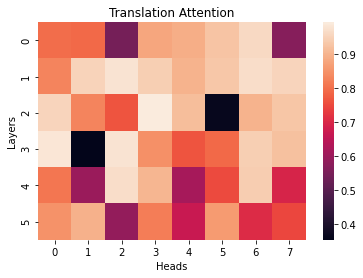

In [91]:
# Translation - Bible para dataset
plotting_confidence_score(test_input_bible,"Translation Attention")

Token indices sequence length is longer than the specified maximum sequence length for this model (1310 > 512). Running this sequence through the model will result in indexing errors


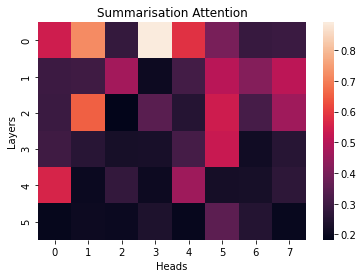

In [92]:
# Summarisation - CNN daily mail dataset
plotting_confidence_score(test_input_cnn,"Summarisation Attention")

Token indices sequence length is longer than the specified maximum sequence length for this model (825 > 512). Running this sequence through the model will result in indexing errors


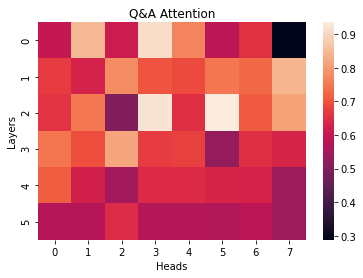

In [93]:
# Question Answering - Boolq
plotting_confidence_score(test_input_boolq,"Q&A Attention")

## Report

On the translation task, we can see that in most heads, the model outputs very high attention scores for at least one word. This is sensible as word like "the" and "a" are often straightforward to translate and thus have high attention scores. It seems that for this specific task most of heads help in determining important words, which are words that are likely to be the right match in the translation.

For the summarisation task, only one head has on average high max attention score. It makes sense has it is very hard to say that a word is a good representation of an entire text. Summarisation will most often be a grouping of words which constitutes the summary and will rarely have a single word being a perfect candidate that summarises the text.

For the question and answering task, the confidence score heatmap seems in the middle of the two above tasks. The average high max attention is fairly high for all heads. Again, this meets our expectations. The model usually have a good idea about which word consitutes the answer and therefore outputs high attention score. This validates our previous takeaway. Indeed, Q&A tasks tend to extract at least one important word that constitutes the answer.